# 🚀 Korpusanalyse – Visualisierung der Textkomplexität

<div class="alert alert-block alert-info"> <b> 🔔 Feinlernziel(e) dieses Kapitels</b></br>
   Sie können die Konzeption der Analyse beschreiben und andere Möglichkeiten des Korpus-Splitting entwerfen. </br>
    Sie können das Konzept eines Balkendiagramms erklären und das erstellte Diagramm interpretieren sowie die Gründe für Ihre Interpretation nennen.

</div>

## Hinweise zur Ausführung des Notebooks
Dieses Notebook kann auf unterschiedlichen Levels erarbeitet werden (siehe Abschnitt ["Technische Voraussetzungen"](../markdown/introduction_requirements)): 
1. Book-Only Mode
2. Cloud Mode: Dafür auf 🚀 klicken und z.B. in Colab ausführen.
3. Local Mode: Dafür auf Herunterladen ↓ klicken und ".ipynb" wählen. 

## Übersicht
Im Folgenden wird die Textkomplexität der einzelnen Pressemitteilungen für unterschiedliche Zeitabschnitte (Monate, Jahre) zusammengefasst und visualisiert. 
1. Einlesen der Tabelle mit den Textkomplexitätsscores
2. Zusammenfassung für Zeitabschnitte
3. Ergebnisse in einem Liniendiagramm visualisieren

<details>
  <summary><b>Informationen zum Ausführen des Notebooks – Zum Ausklappen klicken ⬇️</b></summary>
  
<b>Voraussetzungen zur Ausführung des Jupyter Notebooks</b>
<ol>
<li> Installieren der Bibliotheken </li>
<li>2. Laden der Daten (z.B. über den Command `wget` (s.u.))</li>
<li>3. Pfad zu den Daten setzen</li>
</ol>
Zum Testen: Ausführen der Zelle "load libraries" und der Sektion "Einlesen des Korpus". </br>
Alle Zellen, die mit 🚀 gekennzeichnet sind, werden nur bei der Ausführung des Noteboos in Colab / JupyterHub bzw. lokal ausgeführt. 
</details>

In [ ]:
# 🚀 Install libraries
! pip install pandas matplotlib bokeh

In [6]:
# import libraries for table processing and for compuation of readability metrics
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column, row, layout
from bokeh.models import ColumnDataSource, CustomJS, TextInput, Div, RadioButtonGroup, Switch, TableColumn, DataTable
# Ensure Bokeh output is displayed in the notebook
output_notebook()

Loading BokehJS ...

## 1. Einlesen der Textkomplexitätsscores

<details>
  <summary><b>Informationen zum Ausführen des Notebooks – Zum Ausklappen klicken ⬇️</b></summary>
Zuerst wird der Ordner angelegt, in dem die Textdateien gespeichert werden. Der Einfachheit halber wird die gleich Datenablagestruktur wie in dem <a href="https://github.com/dh-network/quadriga/tree/main">GitHub Repository</a>, in dem die Daten gespeichert sind, vorausgesetzt. </br>
Der Text wird aus GitHub heruntergeladen und in dem Ordner <i>../data/txt/</i> abgespeichert. </br>
Der Pfad kann in der Variable <i>text_path</i> angepasst werden. Die einzulesenden Daten müssen die Endung `.txt` haben. </br>
</details>

In [3]:
# 🚀 Create result directory path
result_dir = Path(r"../results")
if not result_dir.exists():
    result_dir.mkdir()

In [ ]:
# 🚀 Load the results file from GitHub 
#! wget https://raw.githubusercontent.com/dh-network/quadriga-fs-2/tree/develop/results/ -P ../results/

In [7]:
result_path = result_dir / r"metadata_with_readability_scores.csv"

In [8]:
result_df = pd.read_csv(result_path)

Erste 100 Zeilen der Daten angucken:

In [23]:
# Too slow if one with entire data frame

# Convert DataFrame to ColumnDataSource
source = ColumnDataSource(result_df[:100])
        
# Create Table Columns
columns = [TableColumn(field=col, title=col) for col in result_df.head().columns]

# Create DataTable
data_table = DataTable(source=source, columns=columns)

# Display DataTable
output_notebook()  # Use this to render in Jupyter Notebook
show(layout([data_table]))

Loading BokehJS ...

## 3. Analyse

__3.3 Max und Min-Werte --> can be done with dataframe__ ?
* stimmen die Metriken bei der Bestimmung von Max und Min-Werten überein?
* Anzeigen der Sätze? 

## 3.1 Korpus filtern 
* bei Jahr (2011 - 2024)

In [10]:
result_df['date'] = pd.to_datetime(result_df['date'])
results_from_2011_df = result_df[result_df.date.dt.year >= 2011]

## 3.2 Entwicklung über Zeit 
* Vergleich der Metriken-Entwicklung über die Jahre 

In [11]:
metrics = ["Flesch", "ARI", "Coleman_Liau", "Wiener_Sachtextformel"]

In [12]:
metric_mean_year_df = results_from_2011_df.groupby(pd.PeriodIndex(results_from_2011_df['date'], freq="Y"))[metrics].mean()

<Axes: xlabel='date'>

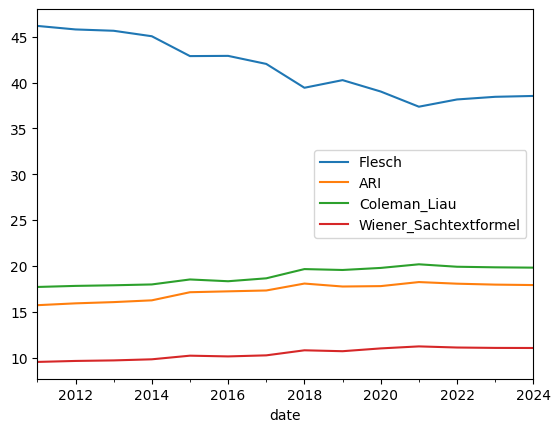

In [13]:
metric_mean_year_df.plot()

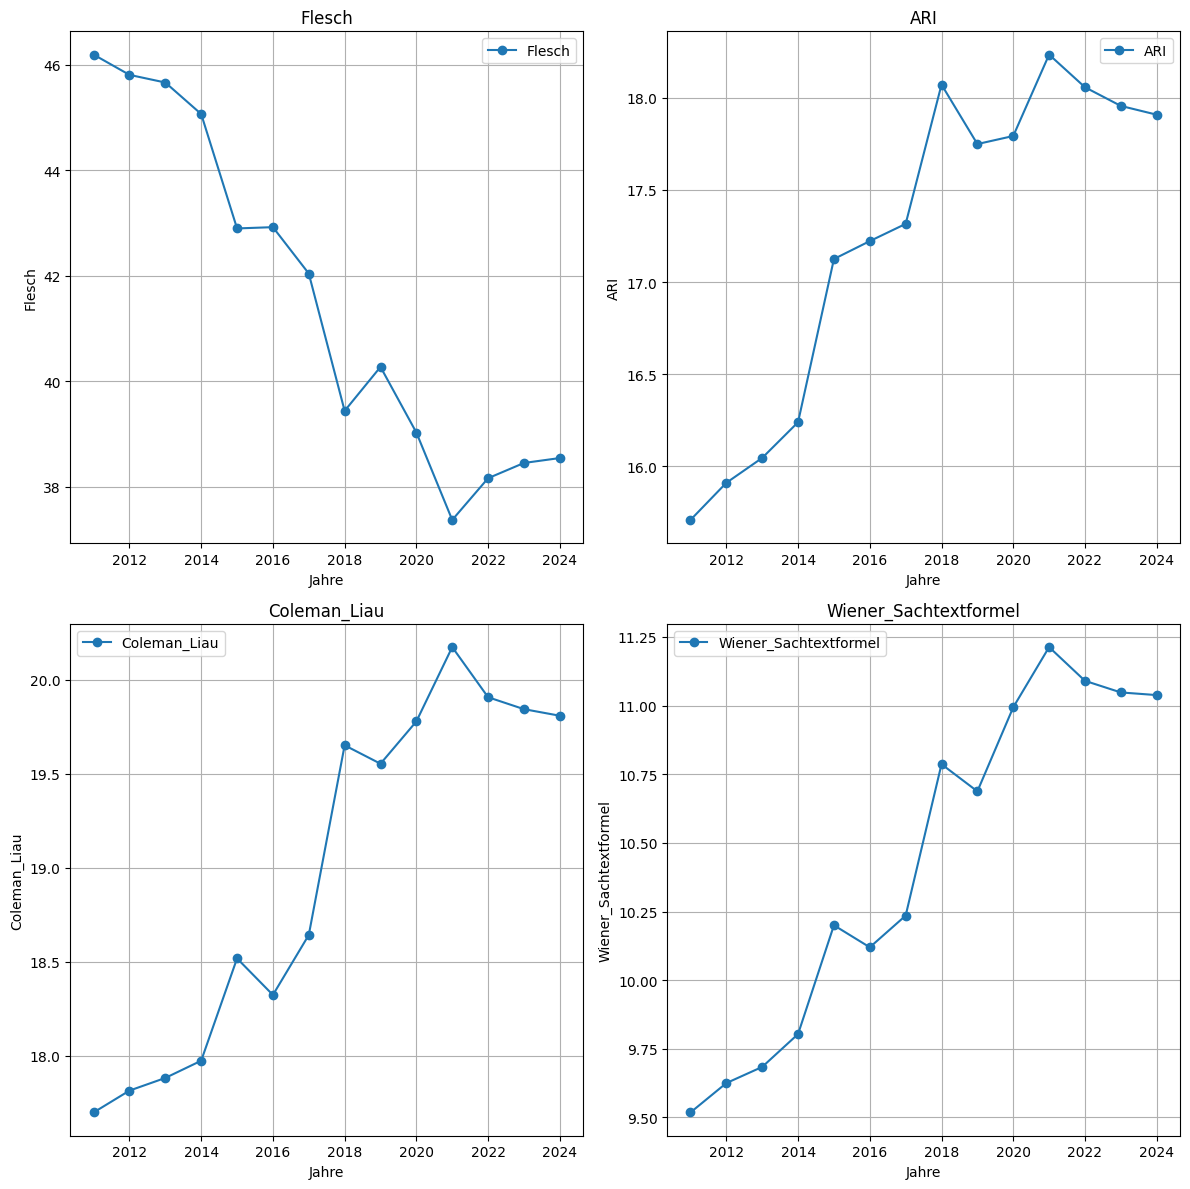

In [14]:
# Create subplots -- attention, they don't start with 0!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()
for i, col in enumerate(metrics):
    axes[i].plot(metric_mean_year_df.index.year, metric_mean_year_df[col], marker='o', label=col)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Jahre')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 3.2 Interaktive Analysedaten vorbereiten
* filter by metric
* filter by time

In [15]:
columns_to_keep = []
columns_to_keep.extend(metrics)
columns_to_keep.append("date")
print(columns_to_keep)

['Flesch', 'ARI', 'Coleman_Liau', 'Wiener_Sachtextformel', 'date']


In [16]:
results_filtered = results_from_2011_df[columns_to_keep]

In [17]:
def plot_with_js(results_filtered_df: pd.DataFrame) -> None:
    """ 
    :param pd.DataFrame merged_df: The merged dataframe of all annotations
    """
    frequency_parameters = ["Y", "M", "W-MON"]
    
    metrics_to_time_frame = {}
    for metric in metrics:
        metrics_to_time_frame[metric] = {}
        for option in frequency_parameters:
            result = results_filtered.groupby(pd.PeriodIndex(results_filtered['date'], freq=option))[metric].mean()
            metrics_to_time_frame[metric][option] = {"x": result.index.to_timestamp(), "y": result.values}
    
    # Set year as default for the plot
    line_source = ColumnDataSource(data=metrics_to_time_frame["Flesch"]["Y"])

    # Create a plot
    p = figure(title=f"Lesbarkeitsmaß", x_axis_type="datetime", x_axis_label='Zeit', 
               y_axis_label='Durschnittlicher Score', width=700, height=400)
    line = p.line('x', 'y', source=line_source, line_width=2, color='blue')

    # RadioButtonGroup to select mode
    radio_button_group_time = RadioButtonGroup(labels=["Yearly", "Monthly", "Weekly"], active=0)
    radio_button_group_metric = RadioButtonGroup(labels=["Flesch", "ARI", "Coleman_Liau", "Wiener_Sachtextformel"], active=0)


    # Callback to update the data based on selected mode
    callback = CustomJS(
        args=dict(
            line=line,
            sources=metrics_to_time_frame,
            radio_button_group_time=radio_button_group_time,
            radio_button_group_metric=radio_button_group_metric
        ),
        code="""                
        // Access the value of the switch
        // const sources = switch_element.active ? relative_sources : absolute_sources;

        // Access the value of the RadioButtonGroup Time
        const mode = radio_button_group_time.active;
        
        // Access the value of the RadioButtonGroup
        const base = radio_button_group_metric.active;
    
        // Retrieve the selected frequency
        const freq = ["Y", "M", "W-MON"][mode];

        // Retrieve the selected metric
        const metric = ["Flesch", "ARI", "Coleman_Liau", "Wiener_Sachtextformel"][base];
    
        // update data source and emit change event
        line.data_source.data = sources[metric][freq];
        line.data_source.change.emit();
    """,
    )

    # Attach the callback to both widgets
    radio_button_group_time.js_on_change('active', callback)
    radio_button_group_metric.js_on_change('active', callback)

    # Layout the RadioButtonGroup and plot
    layout = column(row(radio_button_group_metric, radio_button_group_time), p)
    show(layout)

In [18]:
# not interactive yet, updating needs to be fixed
plot_with_js(results_filtered)